In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from reco_systems.filter import filter_df
from reco_systems.CF_knn import calc_similarity_matrix, get_KNN
from reco_systems.user_game_matrix import get_matrix_user_game

In [ ]:
folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"trictrac_database/users.csv", names=["Username", "User id"])



In [ ]:
# Filter for min_reviews for users & games
min_reviews = 5
rev_filter = filter_df(avis_clean, min_reviews)

11201 10549
3242 3957
3006 3910
3003 3910


In [ ]:
# generate user-game matrix
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(rev_filter)

In [ ]:
# cosine similarity matrix, set k = sqrt(nb users)
cos_sim_matrix, _ = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")
k = int(np.sqrt(cos_sim_matrix.shape[0]))
cos_sim_matrix

array([[0.        , 0.90631531, 0.84503229, ..., 1.        , 1.        ,
        0.98883848],
       [0.90631531, 0.        , 0.70944996, ..., 0.98849347, 1.        ,
        0.99491711],
       [0.84503229, 0.70944996, 0.        , ..., 1.        , 1.        ,
        0.98260143],
       ...,
       [1.        , 0.98849347, 1.        , ..., 0.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.98883848, 0.99491711, 0.98260143, ..., 1.        , 1.        ,
        0.        ]], shape=(3003, 3003))

Division of users by reviews
1. plus que 400
2. entre 100 et 400
3. de 6 à 100

In [ ]:
# Find users for who we will plot distances. Create dataframe : User index (in matrix), User id (in DB), Count reviews (per user)
#users_ids = rev_filter[["User id", "Game id"]].groupby("User id", as_index=True).count().sort_values("Game id", ascending=False).head(12)
users_ids =  rev_filter[["User id", "Game id"]].groupby("User id", as_index=True).count()
users_ids = users_ids[(users_ids["Game id"] >= 100)& (users_ids["Game id"] < 420)].sample(12)

assoc = users_table.to_frame().merge(users_ids, left_on="User id", right_index=True).reset_index()
assoc.columns = ["User index", "User id", "Count reviews"]
user_indices = assoc["User index"].to_numpy() # contains selected users indices

users_ids 

,Game id
User id,
578,231
579,327
2397,134
1924,105
85,122
1198,157
2391,156
3836,140
584,189


In [ ]:
# for each user -> find similar k users -> then find an array of distances (only for these k users)
users_knn = np.array([cos_sim_matrix[user, get_KNN(cos_sim_matrix, k=k, user_ind=user, dtype="cos")[:k]] for user in user_indices])
users_knn.shape

(12, 54)

In [ ]:
user_distances = np.round(users_knn, 2) # eliminate distance precision 
dist_for_df  = user_distances.ravel()   # N-D to 1-D array
users_for_df = np.repeat(user_indices, k) # repeat each user's index k times (to construct dataframe in the next cell)
users_for_df.shape, dist_for_df.shape

((648,), (648,))

In [ ]:
# Constuct Dataframe : where to each user index we associate an array of distances of k nearest users 
# e.g. if for user 0 we get k=3 similar users with distances [d1, d2, d3] then the dataframe will contain
# User index | Distance
# 0          | d1
# 0          | d2
# 0          | d3
distance_to_users = pd.DataFrame({"Distance": dist_for_df, "User index":users_for_df}).sort_values("Distance")

# Group by User index, distance (precision already eliminated) and apply .size(), i.e.
# for each user X we count how many similar users have the distance d.dd to the user X
distance_to_users = distance_to_users.groupby(["Distance", "User index"], as_index=True).size().reset_index(name="Number of users")
distance_to_users

,Distance,User index,Number of users
0,0.59,837,1
1,0.60,1208,1
2,0.61,470,1
3,0.61,1208,1
4,0.62,837,1
...,...,...,...
129,0.82,855,18
130,0.83,691,5
131,0.83,855,3
132,0.84,691,8


Text(0.5, 0.98, 'Users [100-420 reviews]. k = 54 cos')

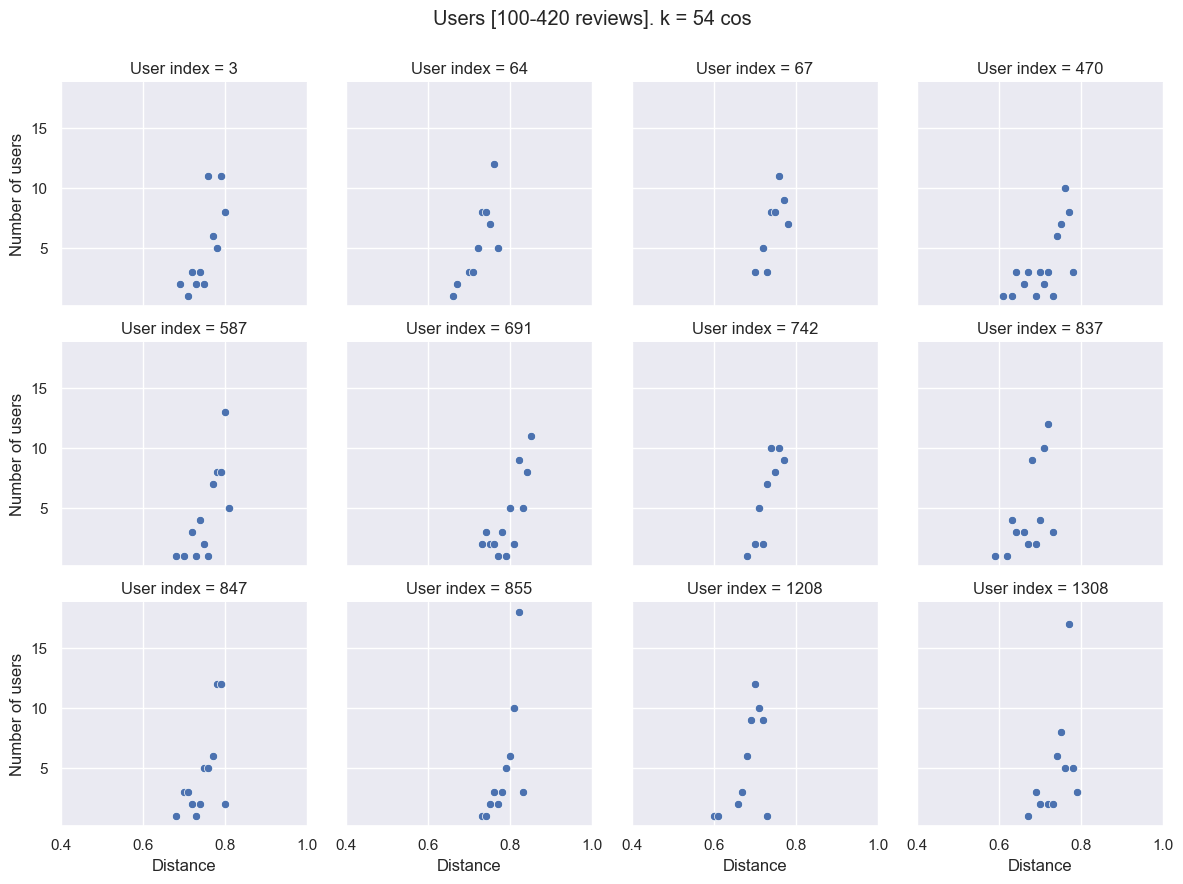

In [ ]:
sns.set_theme(rc={'figure.figsize':(14,6)})

# Grid with 4 columns
g = sns.FacetGrid(distance_to_users, col="User index", col_wrap=4, xlim=(0.4, 1.))

# sns.scatterplot, "Distance", "Number of users" will be on each cell in a grid
g.map(sns.scatterplot, "Distance", "Number of users") 
g.figure.subplots_adjust(top=0.9) # allocate space for title 
g.figure.suptitle("Users [100-420 reviews]. k = 54 cos")